In [1]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
DATA_DIR = 'dataset/'

(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                       shuffle_files=True,
                                       as_supervised=True,
                                       with_info=True,
                                       data_dir=DATA_DIR)
print(train_ds)
print(valid_ds)

Shuffling and writing examples to dataset/eurosat/rgb/2.0.0.incompleteIT25H4/eurosat-train.tfrecord


Dataset eurosat downloaded and prepared to dataset/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
<_OptionsDataset shapes: ((64, 64, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((64, 64, 3), ()), types: (tf.uint8, tf.int64)>


In [3]:
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    version=2.0.0,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat',
    homepage='https://github.com/phelber/eurosat',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=27000,
    splits={
        'train': 27000,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{helber2017eurosat,
        title={EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification},
      

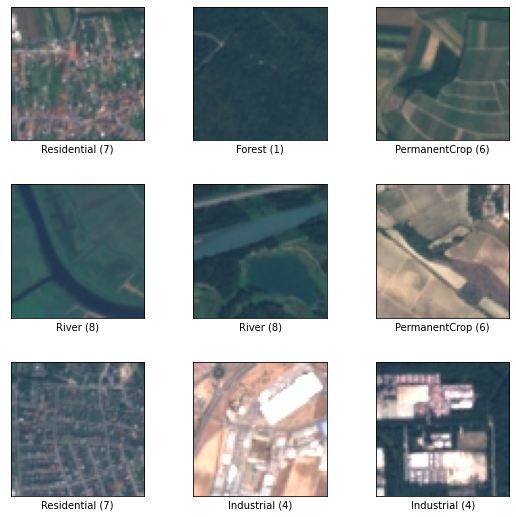

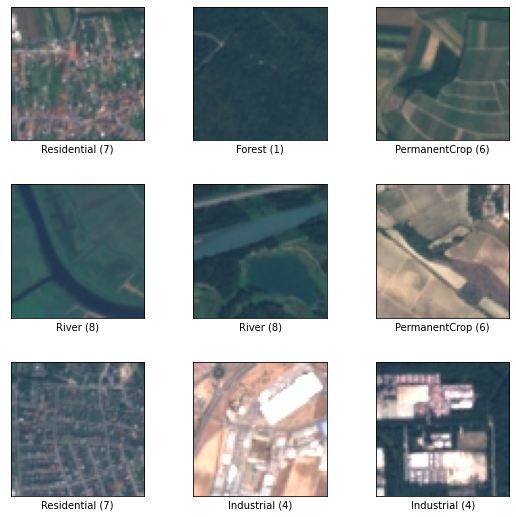

In [4]:
tfds.show_examples(train_ds, info)

image  label
0  [[[26, 42, 65], [25, 41, 64], [26, 43, 63], [2...      9
1  [[[23, 49, 66], [22, 49, 66], [23, 50, 67], [2...      8
2  [[[97, 95, 106], [96, 96, 106], [96, 96, 104],...      9
3  [[[24, 41, 69], [24, 41, 69], [21, 41, 66], [2...      9
4  [[[37, 59, 73], [37, 59, 73], [39, 58, 73], [3...      9
5  [[[199, 164, 162], [197, 163, 161], [199, 166,...      0
6  [[[112, 97, 102], [111, 96, 101], [107, 94, 10...      2
7  [[[149, 120, 122], [148, 120, 119], [152, 121,...      0
8  [[[253, 212, 180], [253, 212, 180], [255, 217,...      0
9  [[[43, 61, 75], [41, 60, 74], [42, 62, 73], [3...      2
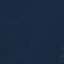
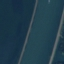
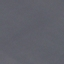
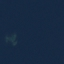
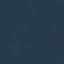
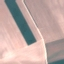
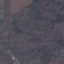
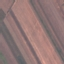
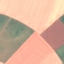
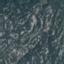

In [5]:
tfds.as_dataframe(valid_ds.take(10), info)

In [6]:
NUM_CLASS = info.features['label'].num_classes
print(NUM_CLASS)

10


In [7]:
print(info.features['label'].int2str(9))

SeaLake


In [8]:
# 데이터 전처리
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def preprocess_data(image, label):
  image = tf.cast(image, tf.float32) / 255.
  return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

In [9]:
def build_model():
  model = tf.keras.Sequential([
                               #Convolution
                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
                               tf.keras.layers.MaxPool2D((2, 2)),

                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
                               tf.keras.layers.MaxPool2D((2, 2)),

                               #Classifier
                               tf.keras.layers.Flatten(),
                               tf.keras.layers.Dense(128, activation='relu'),
                               tf.keras.layers.Dropout(0.3),
                               tf.keras.layers.Dense(64, activation='relu'),
                               tf.keras.layers.Dropout(0.3),
                               tf.keras.layers.Dense(NUM_CLASS, activation='softmax')

  ])
  return model
model = build_model()

In [10]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, validation_data=valid_data, epochs=50)

Epoch 1/50
338/338 [==============================] - 39s 23ms/step - loss: 1.7266 - accuracy: 0.3887 - val_loss: 1.8243 - val_accuracy: 0.3772
Epoch 2/50
338/338 [==============================] - 7s 19ms/step - loss: 1.3284 - accuracy: 0.5285 - val_loss: 1.0954 - val_accuracy: 0.6426
Epoch 3/50
338/338 [==============================] - 7s 19ms/step - loss: 1.1483 - accuracy: 0.5925 - val_loss: 0.8639 - val_accuracy: 0.7007
Epoch 4/50
338/338 [==============================] - 7s 19ms/step - loss: 1.0381 - accuracy: 0.6277 - val_loss: 0.8973 - val_accuracy: 0.6937
Epoch 5/50
338/338 [==============================] - 6s 19ms/step - loss: 0.9768 - accuracy: 0.6499 - val_loss: 0.7423 - val_accuracy: 0.7470
Epoch 6/50
338/338 [==============================] - 7s 19ms/step - loss: 0.8966 - accuracy: 0.6834 - val_loss: 0.7522 - val_accuracy: 0.7581
Epoch 7/50
338/338 [==============================] - 7s 20ms/step - loss: 0.8464 - accuracy: 0.7003 - val_loss: 0.6816 - val_accuracy: 0.769

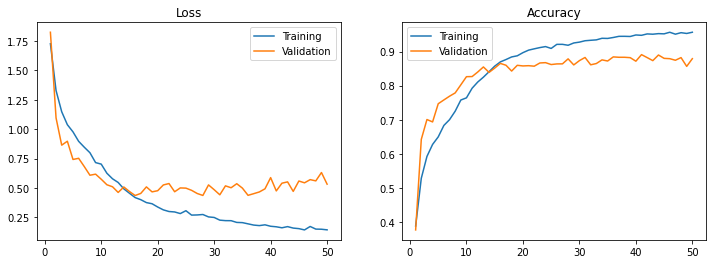

In [11]:
# 손실함수, 정확도 그래프 그리기
def plot_loss_acc(history, epoch):
  loss, val_loss = history.history['loss'], history.history['val_loss']
  acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
  fig, axes = plt.subplots(1, 2, figsize=(12, 4))
  axes[0].plot(range(1, epoch + 1), loss, label='Training')
  axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
  axes[0].legend(loc='best')
  axes[0].set_title('Loss')
  axes[1].plot(range(1, epoch + 1), acc, label='Training')
  axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
  axes[1].legend(loc='best')
  axes[1].set_title('Accuracy')
  plt.show()
plot_loss_acc(history, 50)

Text(0.5, 1.0, 'SeaLake')

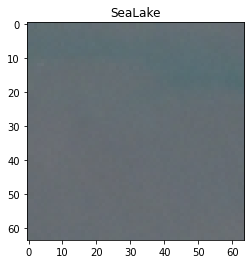

In [12]:
# Data Augmentation
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()
plt.imshow(image)
plt.title(info.features['label'].int2str(label))

In [13]:
# 데이터 증감 전후 비교 시각화 함수
def plot_augmentation(original, augmented):
  fig, axes = plt.subplots(1, 2, figsize=(12, 4))
  axes[0].imshow(original)
  axes[0].set_title('Original')
  axes[1].imshow(augmented)
  axes[1].set_title('Augmented')
  plt.show()

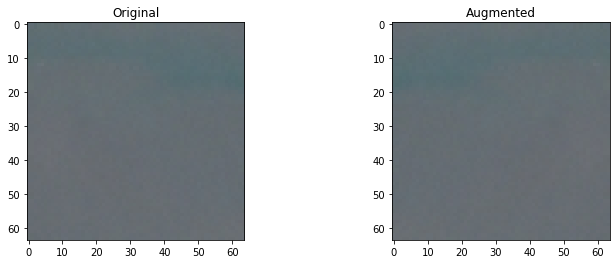

In [14]:
# 좌우 뒤집기
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

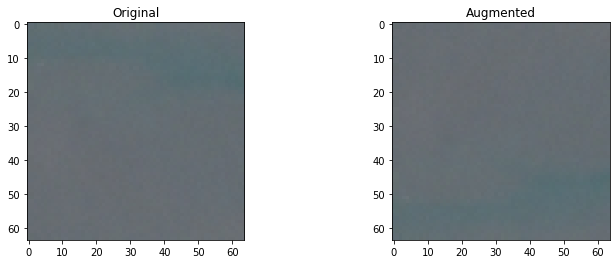

In [15]:
# 상하 뒤집기
up_flip = tf.image.flip_up_down(image)
plot_augmentation(image, up_flip)

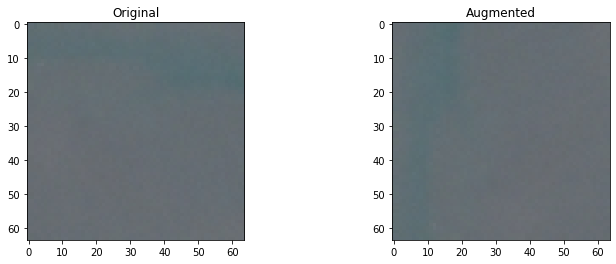

In [16]:
# 회전
rotat90 = tf.image.rot90(image)
plot_augmentation(image, rotat90)

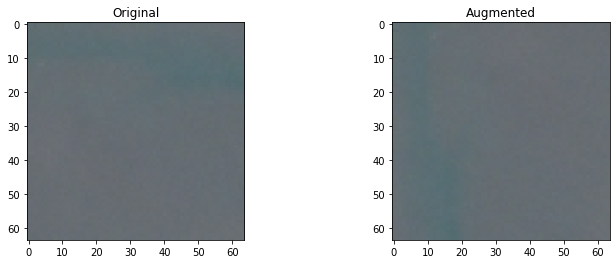

In [17]:
# transpose
transpose = tf.image.transpose(image)
plot_augmentation(image, transpose)

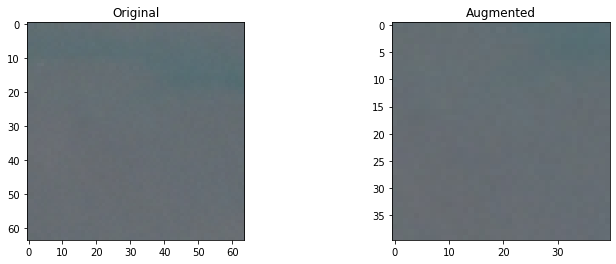

In [18]:
# 이미지 자르기1
crop1 = tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image, crop1)

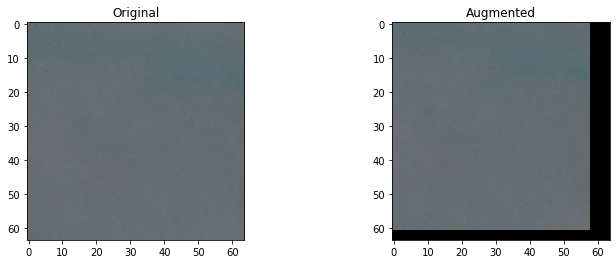

In [19]:
#이미지 자르기2
crop2 = tf.image.resize_with_crop_or_pad(image, 64 + 20, 64 + 20) # 사이즈 키우기
crop2 = tf.image.random_crop(crop2, size=[64, 64, 3])
plot_augmentation(image, crop2)

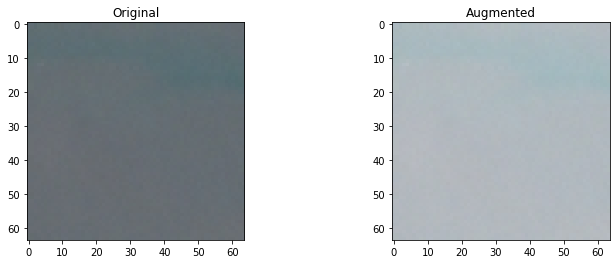

In [20]:
# 이미지 밝기
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

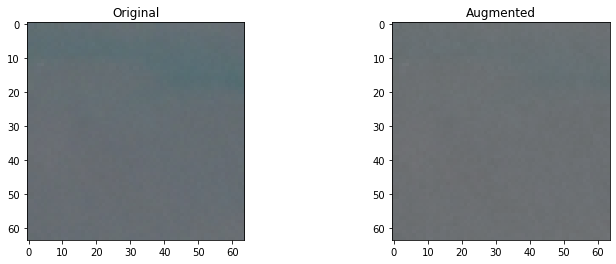

In [21]:
# 채도
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

In [22]:
# 증강 전처리 함수
def data_augmentation(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  image = tf.image.random_brightness(image, max_delta=0.3)
  image = tf.image.random_crop(image, size=[64, 64, 3])
  image = tf.cast(image, tf.float32) / 255.
  return image, label

In [23]:
train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

print(train_aug)
print(valid_aug)

<PrefetchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int64)>
<PrefetchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int64)>


In [24]:
aug_model = build_model()
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
aug_history = aug_model.fit(train_aug, validation_data=valid_aug, epochs=50)

Epoch 1/50
338/338 [==============================] - 11s 29ms/step - loss: 1.9701 - accuracy: 0.2738 - val_loss: 1.7432 - val_accuracy: 0.3552
Epoch 2/50
338/338 [==============================] - 8s 24ms/step - loss: 1.6213 - accuracy: 0.3793 - val_loss: 1.3298 - val_accuracy: 0.5246
Epoch 3/50
338/338 [==============================] - 8s 22ms/step - loss: 1.4629 - accuracy: 0.4396 - val_loss: 1.2431 - val_accuracy: 0.5357
Epoch 4/50
338/338 [==============================] - 8s 23ms/step - loss: 1.3524 - accuracy: 0.4719 - val_loss: 1.1469 - val_accuracy: 0.5754
Epoch 5/50
338/338 [==============================] - 8s 23ms/step - loss: 1.2956 - accuracy: 0.5082 - val_loss: 1.0368 - val_accuracy: 0.6496
Epoch 6/50
338/338 [==============================] - 8s 22ms/step - loss: 1.2321 - accuracy: 0.5388 - val_loss: 0.9554 - val_accuracy: 0.6748
Epoch 7/50
338/338 [==============================] - 9s 25ms/step - loss: 1.1608 - accuracy: 0.5702 - val_loss: 0.9209 - val_accuracy: 0.678

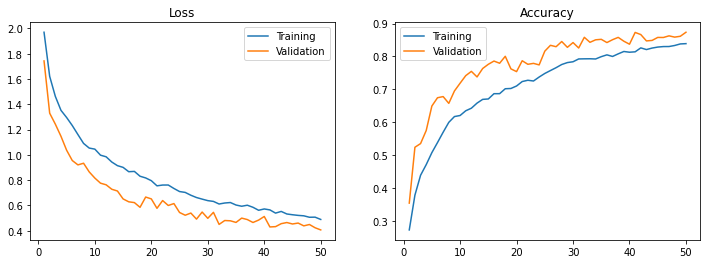

In [25]:
plot_loss_acc(aug_history, 50)

# 전이 학습 (Transfer Learning)

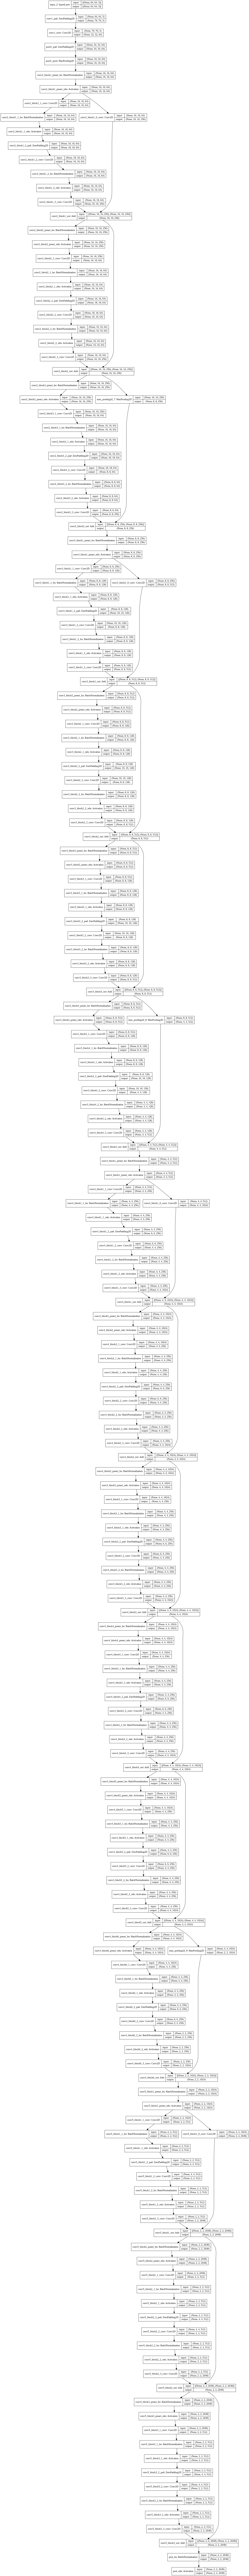

In [27]:
# Pre-trained 모델 (사전 학습된 가중치와 함계 가죠오기)
from tensorflow.keras.applications import ResNet50V2
pre_trained_base = ResNet50V2(include_top=False, weights='imagenet', input_shape=[64, 64, 3])

# 사전 학습된 가중치를 업데이트 되지 않도록 설정
pre_trained_base.trainable = False

from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='resnet50.png')

In [29]:
# Top 층에 Classifier 추가
def buil_trainsfer_classifier():
  model = tf.keras.Sequential([
                               # Pre-trained Base
                               pre_trained_base,
                               # Classifier 출력층
                               tf.keras.layers.Flatten(),
                               tf.keras.layers.Dense(128, activation='relu'),
                               tf.keras.layers.Dropout(0.3),
                               tf.keras.layers.Dense(64, activation='relu'),
                               tf.keras.layers.Dropout(0.3),
                               tf.keras.layers.Dense(NUM_CLASS, activation='softmax')
                               ])
  return model
tc_model = buil_trainsfer_classifier()
tc_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2, 2, 2048)        23564800  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)               

In [31]:
tc_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
tc_history = tc_model.fit(train_aug, validation_data=valid_aug, epochs=50)

Epoch 1/50
338/338 [==============================] - 20s 46ms/step - loss: 1.0146 - accuracy: 0.6717 - val_loss: 0.6041 - val_accuracy: 0.8011
Epoch 2/50
338/338 [==============================] - 13s 38ms/step - loss: 0.7381 - accuracy: 0.7639 - val_loss: 0.5474 - val_accuracy: 0.8207
Epoch 3/50
338/338 [==============================] - 13s 39ms/step - loss: 0.6480 - accuracy: 0.7937 - val_loss: 0.4922 - val_accuracy: 0.8402
Epoch 4/50
338/338 [==============================] - 14s 40ms/step - loss: 0.6107 - accuracy: 0.8062 - val_loss: 0.4891 - val_accuracy: 0.8404
Epoch 5/50
338/338 [==============================] - 13s 39ms/step - loss: 0.5715 - accuracy: 0.8150 - val_loss: 0.4708 - val_accuracy: 0.8439
Epoch 6/50
338/338 [==============================] - 13s 38ms/step - loss: 0.5426 - accuracy: 0.8261 - val_loss: 0.4503 - val_accuracy: 0.8478
Epoch 7/50
338/338 [==============================] - 14s 40ms/step - loss: 0.5237 - accuracy: 0.8304 - val_loss: 0.4480 - val_accuracy:

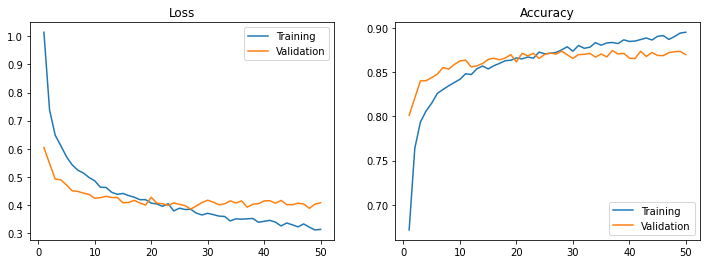

In [32]:
plot_loss_acc(tc_history, 50)